# Task 3, 4 & 5: Data Enrichment, API, and Orchestration

This notebook demonstrates the completion of Tasks 3 (YOLO Enrichment), 4 (Analytical API), and 5 (Dagster Pipeline).

## Task 3: Data Enrichment with YOLO

We have processed the downloaded images using YOLOv8 to detect objects. The results are stored in `data/processed/yolo_results.csv` and have been loaded into the data warehouse.

In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Setup DB connection
from src.loader import get_db_engine
engine = get_db_engine()

In [2]:
# 1. Load CSV Results
csv_path = os.path.join(project_root, 'data', 'processed', 'yolo_results.csv')
try:
    yolo_df = pd.read_csv(csv_path)
    print(f"Loaded {len(yolo_df)} detection records from CSV.")
    display(yolo_df.head())
except FileNotFoundError:
    print("yolo_results.csv not found. Make sure you have run the detection script.")

Loaded 288 detection records from CSV.


,message_id,channel_name,image_path,detected_classes,confidence_score,image_category
0,10,CheMed123,data\raw\images\CheMed123\10.jpg,[],0.000000,other
1,11,CheMed123,data\raw\images\CheMed123\11.jpg,[74],0.427293,other
2,13,CheMed123,data\raw\images\CheMed123\13.jpg,"[52, 54]",0.503855,other
3,14,CheMed123,data\raw\images\CheMed123\14.jpg,[],0.000000,other
4,15,CheMed123,data\raw\images\CheMed123\15.jpg,[],0.000000,other


In [3]:
# 2. Query Data Warehouse Integration
print("Querying fct_image_detections from PostgreSQL...")
query = text("""
    SELECT 
        c.channel_name, 
        f.image_category, 
        f.confidence_score,
        f.detected_classes
    FROM fct_image_detections f
    JOIN dim_channels c ON f.channel_key = c.channel_key
    LIMIT 5
""")
with engine.connect() as conn:
    result = pd.read_sql(query, conn)
    display(result)

Querying fct_image_detections from PostgreSQL...


,channel_name,image_category,confidence_score,detected_classes
0,CheMed123,other,0.000000,[]
1,CheMed123,product_display,0.326003,[41]
2,CheMed123,lifestyle,0.868440,[0]
3,CheMed123,promotional,0.740869,"[0, 41]"
4,CheMed123,lifestyle,0.907673,[0]


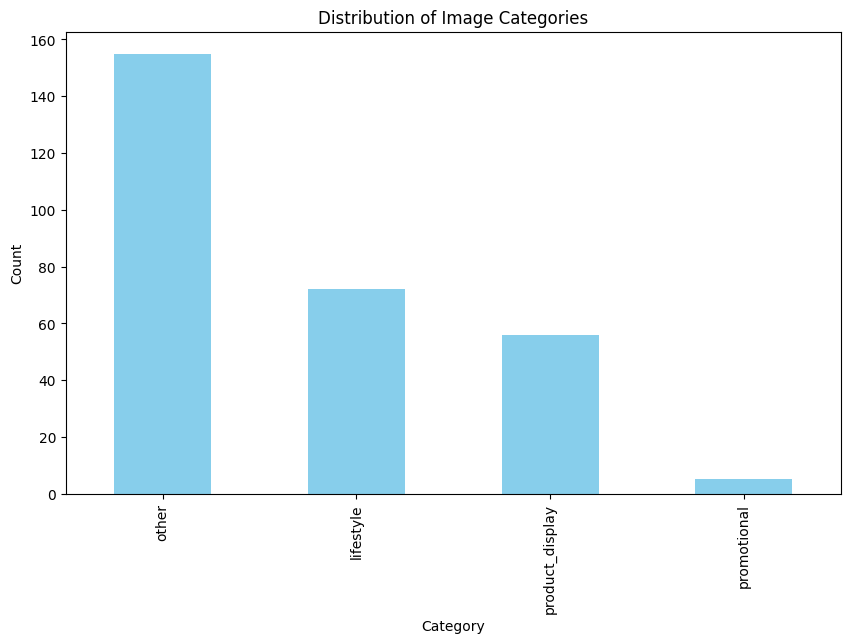

In [4]:
# 3. Visualization
if 'yolo_df' in locals():
    plt.figure(figsize=(10, 6))
    yolo_df['image_category'].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Distribution of Image Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()

## Task 4: Analytical API

We have implemented a FastAPI application in `api/main.py`. Below, we use `TestClient` to verify the endpoints without launching a separate server process.

In [5]:
from fastapi.testclient import TestClient
from api.main import app
import json

client = TestClient(app)

def print_json(response):
    print(json.dumps(response.json(), indent=2))

# 1. Health Check
response = client.get("/health")
print("GET /health:")
print_json(response)

2026-01-21 18:35:15,185 - INFO - HTTP Request: GET http://testserver/health "HTTP/1.1 200 OK"


GET /health:
{
  "status": "healthy"
}


In [6]:
# 2. Top Products
response = client.get("/api/reports/top-products?limit=5")
print("GET /api/reports/top-products:")

print_json(response)

2026-01-21 18:40:16,558 - INFO - HTTP Request: GET http://testserver/api/reports/top-products?limit=5 "HTTP/1.1 200 OK"


GET /api/reports/top-products:
[
  {
    "product": "\ud83d\udccc",
    "mention_count": 35
  },
  {
    "product": "\u2b06",
    "mention_count": 21
  },
  {
    "product": "PHARMAKON",
    "mention_count": 8
  },
  {
    "product": "ENSURE",
    "mention_count": 7
  },
  {
    "product": "NEW",
    "mention_count": 6
  }
]


In [7]:
# 3. Channel Activity
# Get a channel name from the DB first
channel_name = 'lobelia4cosmetics' # Default fallback
if 'result' in locals() and not result.empty:
    channel_name = result.iloc[0]['channel_name']

response = client.get(f"/api/channels/{channel_name}/activity")
print(f"GET /api/channels/{channel_name}/activity (First 3 days):")
print(json.dumps(response.json()[:3], indent=2))

2026-01-21 18:40:25,423 - INFO - HTTP Request: GET http://testserver/api/channels/CheMed123/activity "HTTP/1.1 200 OK"


GET /api/channels/CheMed123/activity (First 3 days):
[
  {
    "date": "2022-09-05T00:00:00",
    "message_count": 1
  },
  {
    "date": "2022-09-06T00:00:00",
    "message_count": 1
  },
  {
    "date": "2022-09-07T00:00:00",
    "message_count": 1
  }
]


In [8]:
# 4. Visual Content Stats
response = client.get("/api/reports/visual-content")
print("GET /api/reports/visual-content:")
print_json(response)

2026-01-21 18:40:35,490 - INFO - HTTP Request: GET http://testserver/api/reports/visual-content "HTTP/1.1 200 OK"


GET /api/reports/visual-content:
[
  {
    "channel_name": "CheMed123",
    "total_images": 59,
    "avg_confidence": 0.48069986044350316,
    "promotional_count": 3,
    "product_display_count": 10
  },
  {
    "channel_name": "lobelia4cosmetics",
    "total_images": 96,
    "avg_confidence": 0.3357558408752084,
    "promotional_count": 0,
    "product_display_count": 36
  },
  {
    "channel_name": "Thequorachannel",
    "total_images": 53,
    "avg_confidence": 0.4452510549212402,
    "promotional_count": 0,
    "product_display_count": 1
  },
  {
    "channel_name": "tikvahpharma",
    "total_images": 27,
    "avg_confidence": 0.4900337921248542,
    "promotional_count": 1,
    "product_display_count": 6
  }
]


## Task 5: Pipeline Orchestration

We have defined a Dagster pipeline in `pipeline.py` that orchestrates the Scraper -> Loader -> YOLO -> dbt workflow.

In [9]:
pipeline_path = os.path.join(project_root, 'pipeline.py')
with open(pipeline_path, 'r') as f:
    print(f.read())

from dagster import op, job, Config, Out
import subprocess
import os
import sys

@op
def scrape_telegram_data():
    """Run the telegram scraper script."""
    # Use the project's virtual environment python
    python_exe = os.path.join("venv8", "Scripts", "python.exe")
    result = subprocess.run([python_exe, "src/scraper.py", "--limit", "100"], check=True)
    return "Scraping completed"

@op
def load_raw_to_postgres(wait_for_scrape):
    """Run the loader script to move JSON data to Postgres."""
    python_exe = os.path.join("venv8", "Scripts", "python.exe")
    result = subprocess.run([python_exe, "src/loader.py"], check=True)
    return "Loading completed"

@op
def run_yolo_enrichment(wait_for_scrape):
    """Run the YOLO object detection script."""
    python_exe = os.path.join("venv8", "Scripts", "python.exe")
    result = subprocess.run([python_exe, "src/yolo_detect.py"], check=True)
    return "YOLO enrichment completed"

@op
def run_dbt_transformations(wait_for_load, wait_for

To run this pipeline, execute the following command in your terminal:

```bash
dagster dev -f pipeline.py
```